# Download dataset from gDrive

In [1]:
!pip install -U -q PyDrive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
file_id = '1jBdjdBHjG-UpxEk5-z1fd1XxyfjvVmJ9' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('dataset2.zip')

In [4]:
!ls #to verify content

adc.json  dataset2.zip	sample_data


# Unzip dataset

In [5]:
!unzip "/content/dataset2.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset2/TrainTest/WithoutMask/2264.png  
  inflating: /content/dataset2/TrainTest/WithoutMask/2265.png  
  inflating: /content/dataset2/TrainTest/WithoutMask/2266.png  
  inflating: /content/dataset2/TrainTest/WithoutMask/2267.png  
  inflating: /content/dataset2/TrainTest/WithoutMask/2268.png  
  inflating: /content/dataset2/TrainTest/WithoutMask/2269.png  
  inflating: /content/dataset2/TrainTest/WithoutMask/2270.png  
  inflating: /content/dataset2/TrainTest/WithoutMask/2271.png  
  inflating: /content/dataset2/TrainTest/WithoutMask/2272.png  
  inflating: /content/dataset2/TrainTest/WithoutMask/2273.png  
  inflating: /content/dataset2/TrainTest/WithoutMask/2274.png  
  inflating: /content/dataset2/TrainTest/WithoutMask/2275.png  
  inflating: /content/dataset2/TrainTest/WithoutMask/2276.png  
  inflating: /content/dataset2/TrainTest/WithoutMask/2277.png  
  inflating: /content/dataset2/TrainTest/WithoutMask/

In [56]:
# !rm -rf "/content/Face Mask Dataset"

# Import library

In [6]:
import tensorflow as tf
import os
import time
from matplotlib import pyplot as plt

# Data preparation

In [11]:
# Membuat direktori base

base_dir = '/content/dataset2/TrainTest'

In [18]:
# Cek direktorib
# print(os.listdir(train_dir))
# print(os.listdir(test_dir))

['WithoutMask', 'WithMask']
['WithoutMask', 'WithMask']


In [21]:
# train_withMask_dir = os.path.join(train_dir, 'WithMask')
# train_noMask_dir = os.path.join(train_dir, 'WithoutMask')
 
# test_withMask_dir = os.path.join(test_dir, 'WithMask')
# test_noMask_dir = os.path.join(test_dir, 'WithoutMask')

In [14]:
# Membuat objek ImageDataGenerator (data training dan data testing)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range=0.2,
                    fill_mode='nearest',
                    validation_split=0.1)

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=50,
                    horizontal_flip=True,
                    shear_range=0.2,
                    fill_mode='nearest',
                    validation_split=0.1)

In [15]:
train_generator = train_datagen.flow_from_directory(
        base_dir, # Direktori data train
        target_size=(224, 224), # Mengubah resolusi seluruh gambar menjadi 150x150
        class_mode='binary',
        subset="training") 

test_generator = test_datagen.flow_from_directory(
        base_dir, # Direktori data val
        target_size=(224, 224), # Mengubah resolusi seluruh gambar menjadi 150x150
        class_mode='binary',
        subset='validation') 

Found 9870 images belonging to 2 classes.
Found 1096 images belonging to 2 classes.


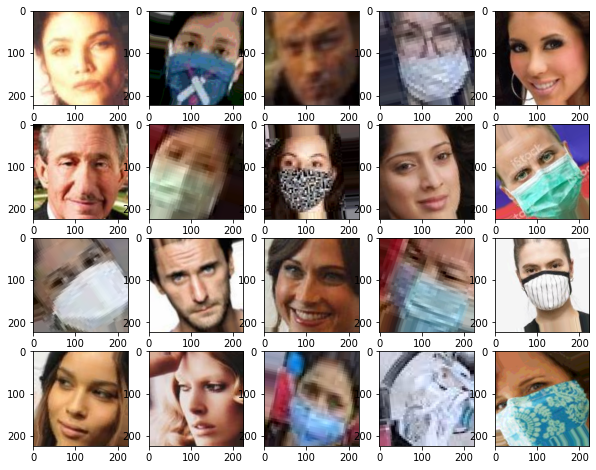

In [16]:
# Show more test set Images
fig, axs = plt.subplots(4, 5, figsize=(10,8))
for x in range(4):
    for y in range(5):
        img, label = train_generator.next()
        axs[x, y].imshow(img[1])

# Building model

In [17]:
# Membangun Arsitektur CNN dengan bantuan keras sequential

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [33]:
# Callback untuk mencegah overfitting dan menghentikan training setelah akurasi mencapai 97%

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.97):
            print("\nTraining berhenti karena akurasi sudah mencapai 97% untuk mencegah overfitting")
            self.model.stop_training = True

callbacks = myCallback()

In [19]:
test_generator.samples

1096

In [20]:
batch_size = 32
epochs = 20
steps_per_epoch = 32
# validation_steps = 32


start_time = time.time()

latih = model.fit(
    train_generator, 
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    verbose=2, 
    validation_data=test_generator)

score = model.evaluate(train_generator, verbose=0)
print("Test loss: {}".format(score[0]))
print("Test acuracy: {}".format(score[1]))

elapsed_time = time.time() - start_time;
print("Elapsed time: {}".format(time.strftime('%H:%M:%S', time.gmtime(elapsed_time))))

Epoch 1/20
32/32 - 153s - loss: 0.5109 - accuracy: 0.7617 - val_loss: 0.2373 - val_accuracy: 0.9361 - 153s/epoch - 5s/step
Epoch 2/20
32/32 - 151s - loss: 0.1849 - accuracy: 0.9277 - val_loss: 0.1157 - val_accuracy: 0.9644 - 151s/epoch - 5s/step
Epoch 3/20
32/32 - 151s - loss: 0.1326 - accuracy: 0.9580 - val_loss: 0.1497 - val_accuracy: 0.9462 - 151s/epoch - 5s/step
Epoch 4/20
32/32 - 150s - loss: 0.1437 - accuracy: 0.9521 - val_loss: 0.2294 - val_accuracy: 0.9151 - 150s/epoch - 5s/step
Epoch 5/20
32/32 - 150s - loss: 0.1355 - accuracy: 0.9580 - val_loss: 0.1521 - val_accuracy: 0.9425 - 150s/epoch - 5s/step
Epoch 6/20
32/32 - 150s - loss: 0.1252 - accuracy: 0.9561 - val_loss: 0.1599 - val_accuracy: 0.9398 - 150s/epoch - 5s/step
Epoch 7/20
32/32 - 152s - loss: 0.1407 - accuracy: 0.9463 - val_loss: 0.1826 - val_accuracy: 0.9343 - 152s/epoch - 5s/step
Epoch 8/20
32/32 - 152s - loss: 0.1343 - accuracy: 0.9482 - val_loss: 0.1750 - val_accuracy: 0.9398 - 152s/epoch - 5s/step
Epoch 9/20
32/32

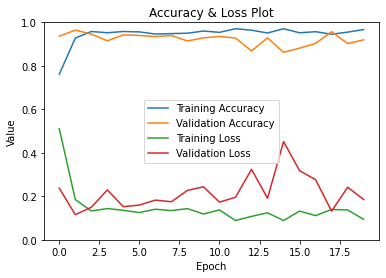

In [31]:
# Menampilkan grafik tingkat akurasi model

from matplotlib import pyplot as plt
plt.plot(latih.history['accuracy'], label='Training Accuracy')
plt.plot(latih.history['val_accuracy'], label='Validation Accuracy')
plt.plot(latih.history['loss'], label='Training Loss')
plt.plot(latih.history['val_loss'], label='Validation Loss')
plt.title('Accuracy & Loss Plot')
plt.ylim([0,1])
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="center")
plt.show()

# Save Model

In [34]:
#Save model

model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model2.h5")
print("Saved model to disk as 'model2.h5' and 'model2.json'")

Saved model to disk as 'model2.h5' and 'model2.json'
